In [16]:
from networkx.readwrite.pajek import make_qstr
from datasketch import MinHash
import networkx as nx
import re
import json
import os
from random import shuffle
import tlsh
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import copy

from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

%matplotlib inline

main_graphA = json.loads(open('ghidra_mods/graphA.json', 'r').read())
main_graphB = json.loads(open('ghidra_mods/graphB.json', 'r').read())


def jaccard(a, b):
    a = set(a)
    b = set(b)
    if len(a.union(b)) == 0:
       return 0
    else:
        return len(a.intersection(b)) / len(a.union(b))

inst_id = 3
def processOpCodes(graph, proc_format="none"):
    new_graph = copy.deepcopy(graph.copy())
    for func in graph:
        new_graph[func][inst_id] = process_opcode(new_graph[func][inst_id], proc_format)
    return new_graph



class Normalizer(object):
    def __init__(self):
        self.counter = -1

    def __call__(self, match):
        self.counter += 1
        return 'r{0}'.format(self.counter)


# compiler generated differences
similarInstructions = {"adr.w":"adr", "ldr.w":"ldr", "mov.w":"mov", "movw":"mov"}

class Replacer(object): 
    def __call__(self, match):
        if match.group(0) in similarInstructions:
            return similarInstructions[match.group(0)]
        return match.group(0)


# none
# normalize1
# normalize2
# normalize3
# opcodes
# instruction

proc_format = "none"
replacer = Replacer()


def process_opcode(opcode_sequence, proc_format="none"):
    if type(opcode_sequence) == list:
        opcode_sequence = " ".join(opcode_sequence)
    
    opcode_sequence = re.sub('0x[a-fA-F0-9]{8}', ' ', opcode_sequence)
    if proc_format == "none":
        opcode_sequence = re.sub('[\[\]\,\&]', ' ', opcode_sequence)
        opcode_sequence = re.sub('\s+', ' ', opcode_sequence)
        return opcode_sequence.strip().split(' ')
    elif proc_format == "normalize1":
        normalize = Normalizer()
        opcode_sequence = re.sub('[\&]', ' ', opcode_sequence)
        opcode_sequence = re.sub('r(1[0-2]|[0-9])', normalize, opcode_sequence)
        return opcode_sequence
    elif proc_format == "normalize2":
        instructions = ""
        for instruction in opcode_sequence.strip().split('&'):
            normalize = Normalizer()
            instructions += " " +re.sub('r(1[0-2]|[0-9])', normalize, instruction)
        return instructions.strip()
    elif proc_format == "normalize3":
        replace_pattern = re.compile('|'.join(map(re.escape, similarInstructions.keys())))
        return replace_pattern.sub(replacer, opcode_sequence)  
    elif proc_format == "opcodes":
        return [x.split(" ")[0] for x in opcode_sequence.strip().split('&')]
    
    elif proc_format == "instruction":
        return opcode_sequence.strip().split('&')
      



graphA = processOpCodes(main_graphA)
graphB = processOpCodes(main_graphB)

vocab = []
x_label = []
y_label = []
for func in graphA:
    y_label.append(func)
    opcodes = graphA[func][inst_id]
    vocab.extend(opcodes)
for func in graphB:
    x_label.append(func)
    opcodes = graphB[func][inst_id]
    vocab.extend(opcodes)
vocab = set(vocab)


def create_hash_func(size: int):
    # function for creating the hash vector/function
    hash_ex = list(range(1, len(vocab)+1))
    shuffle(hash_ex)
    return hash_ex


def build_minhash_func(vocab_size: int, nbits: int):
    # function for building multiple minhash vectors
    hashes = []
    for _ in range(nbits):
        hashes.append(create_hash_func(vocab_size))
    return hashes


# create 20 minhash vectors
minhash_func = build_minhash_func(len(vocab), 20)


def create_sig(vector: list):
    # use this function for creating our signatures (eg the matching)
    signature = []
    for func in minhash_func:
        for i in range(1, len(vocab)+1):
            idx = func.index(i)
            signature_val = vector[idx]
            if signature_val == 1:
                signature.append(idx)
                break
    return signature


def split_vector(signature, b):
    assert len(signature) % b == 0
    r = int(len(signature) / b)
    # code splitting signature in b parts
    subvecs = []
    for i in range(0, len(signature), r):
        subvecs.append(signature[i: i+r])
    return subvecs


def compare_minhashB(nodeA, nodeB):
    # m1, m2 = MinHash(num_perm=64), MinHash(num_perm=64)
    # for d in dataA:
    #     m1.update(d.encode('utf8'))
    # for d in dataB:
    #     m2.update(d.encode('utf8'))
    # return m1.jaccard(m2) > 0.5
    pass


def compare_tlsh(a, b):
    a = str.encode(' '.join(a))
    b = str.encode(' '.join(b))
    try:
        h1 = tlsh.hash(a)
        h2 = tlsh.hash(b)
        return tlsh.diff(h1, h2)
    except:
        return 1000

def compare_jaccard(a, b):
    return round(jaccard(set(a), set(b)), 3)


def split_by_2(op_list):
    return [' '.join([op_list[i], op_list[i+1]]) for i in range(len(op_list)) if i != len(op_list)-1]


def compare_2gram_jaccard(a, b):
    a = split_by_2(a)
    b = split_by_2(b)
    return round(jaccard(a, b), 3)


def compare_minhashA(a, b):
    a_1hot = [1 if x in a else 0 for x in vocab]
    b_1hot = [1 if x in b else 0 for x in vocab]
    a_sig = create_sig(a_1hot)
    b_sig = create_sig(b_1hot)
    return jaccard(a_sig, b_sig)


def compare(a, b):
    return compare_2gram_jaccard(a, b)


def getOpCode(aggregation_depth, graph, func):
    opcode = graph[func][inst_id]
    if aggregation_depth > 0:
        for child_func in graph[func][0]:
            opcode += getOpCode(0, graph, child_func)
            if aggregation_depth == 2:
                for child_func2 in graph[child_func][0]:
                    opcode += getOpCode(0, graph, child_func2)

    return opcode

def add_color(val):
    color = 'red' if (val >= 0) and (val < 0.6) else 'green'
    return 'color: %s' % color
                                    
def add_opacity(val):
    opacity = 20 if (val >= 0) and (val < 0.6) else None
    if opacity:
        return 'opacity: %s%%' % opacity
    return None

In [17]:
# Check nodes we know are similar
# a = main_graphA["0x20004a50"][2]
# b = main_graphB["0x20004aa8"][2]
# print("Simple Jaccard", compare_jaccard(a, b))
# print("2 gram Jaccard", compare_2gram_jaccard(a, b))
# print("Minhash Score", compare_minhashA(a, b))
# print("TLSH score", compare_tlsh(a, b))

In [18]:
aggregation_depth = 0
include_peripheral = False
normalize = False

def calc_sim(compareFunc, graphA, graphB):
    scores = []
    for funcA in graphA:
        opcodeA = getOpCode(aggregation_depth, graphA, funcA)
        result = []
        for funcB in graphB:
            opcodeB = getOpCode(aggregation_depth, graphB, funcB)
            result.append(compareFunc(opcodeA, opcodeB))
        scores.append(result)
        
    return scores


if(normalize):
    for i in range(len(scores)):
        result = scores[i]
        max_value = max(result)
        scores[i] = [(1 - (x/max_value)) for x in result]

In [19]:
import ipython_genutils
def draw_results(scores):
    labels = []
    for i in range(len(scores)):
        item = scores[i]
        max_value = max(item)
        max_index = item.index(max_value)
        max_label = x_label[max_index]
        labels.append([max_label])
        scores[i] = [min(item), sum(item)/len(item), max_value]
        
    [labels[x].append(y_label[x]) for x in range(len(scores))]
    combined = zip(scores, labels)
    zipped_sorted = sorted(combined, key=lambda x: x[0][2])
    sorted_scores, sorted_labels = map(list, zip(*zipped_sorted))
    print(sorted_labels)

    scores_np = np.array(sorted_scores)
    df = pd.DataFrame(scores_np, columns=["min", "avg", "max"], index=[x[1] for x in sorted_labels])
#     ttips_data = [[x[0]] for x in sorted_labels]
#     ttips_data = [[x[0] + "" + " ".join(graphA[x[1]][2])] for x in sorted_labels]

    ttips_data = [[x[0] + " :::---> " + " ".join(graphA[x[1]][inst_id]) + " ====================?  " + x[1] + " :::---> "  + " ".join(graphB[x[0]][inst_id]) + "  : : : : :  differences" + str(set(graphA[x[1]][inst_id]).symmetric_difference(set(graphB[x[0]][inst_id])))] for x in sorted_labels]
    
    ttips = pd.DataFrame(data=ttips_data, columns=df.columns[[2]], index=df.index)
    s2 = df.style.applymap(add_color).set_tooltips(ttips)
    display(s2)

    sns.lineplot(y_label, [x[2] for x in scores])
    plt.show()
    
    low_scores = []
    index = 0
    while sorted_scores[index][2] < 1:
        low_scores.append((sorted_labels[index],sorted_scores[index]))
        index = index + 1
    return low_scores

In [20]:
# scores = calc_sim(compare_jaccard, graphA, graphB)
# draw_results(scores)

In [21]:
print(len(graphA))

859


[['0x200076ce', '0x2001da48'], ['0x2001d3e8', '0x2000ef92'], ['0x2001a3d8', '0x2001c76a'], ['0x2000f776', '0x200074f8'], ['0x2000be9a', '0x20012858'], ['0x2000b988', '0x2000bc4e'], ['0x20014568', '0x200129be'], ['0x2000afe0', '0x20008fa4'], ['0x2000560a', '0x2000e98e'], ['0x2001467c', '0x20013990'], ['0x20008962', '0x20006ef4'], ['0x2000475e', '0x20004824'], ['0x2000baa6', '0x200109ae'], ['0x2000475e', '0x200047d6'], ['0x20012710', '0x20011452'], ['0x20007a3e', '0x20004876'], ['0x200129ce', '0x200124f6'], ['0x20004c50', '0x20011286'], ['0x2000b4be', '0x2000b3d8'], ['0x2001467c', '0x20015590'], ['0x20007620', '0x20007918'], ['0x2001a7ae', '0x2001ac46'], ['0x20010b70', '0x200109f4'], ['0x2000b6f2', '0x2000b942'], ['0x20009032', '0x2000915e'], ['0x2000b824', '0x2000ba98'], ['0x20008fc6', '0x200090ba'], ['0x200093ac', '0x200094f4'], ['0x2000b8a0', '0x2000bb3e'], ['0x2001603e', '0x200164fc'], ['0x2000f776', '0x2000fb94'], ['0x20009334', '0x2000947a'], ['0x200055d0', '0x2000567a'], ['0x2000b

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


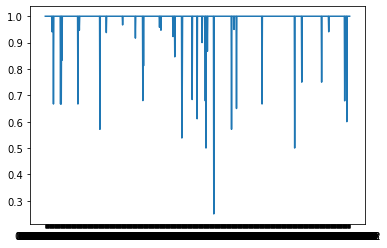

[(['0x200076ce', '0x2001da48'], [0.0, 0.032837869822485294, 0.25]),
 (['0x2001d3e8', '0x2000ef92'], [0.0, 0.07303786982248518, 0.5]),
 (['0x2001a3d8', '0x2001c76a'], [0.0, 0.12469112426035471, 0.5]),
 (['0x2000f776', '0x200074f8'], [0.0, 0.20052071005917202, 0.538]),
 (['0x2000be9a', '0x20012858'], [0.0, 0.18868639053254452, 0.571]),
 (['0x2000b988', '0x2000bc4e'], [0.0, 0.1314852071005915, 0.571]),
 (['0x20014568', '0x200129be'], [0.0, 0.19777633136094663, 0.6]),
 (['0x2000afe0', '0x20008fa4'], [0.0, 0.21256094674556214, 0.611]),
 (['0x2000560a', '0x2000e98e'], [0.0, 0.2271751479289945, 0.65]),
 (['0x2001467c', '0x20013990'], [0.0, 0.2172579881656804, 0.667]),
 (['0x20008962', '0x20006ef4'], [0.0, 0.08825680473372781, 0.667]),
 (['0x2000475e', '0x20004824'], [0.0, 0.16734792899408285, 0.667]),
 (['0x2000baa6', '0x200109ae'], [0.0, 0.23860473372781102, 0.667]),
 (['0x2000475e', '0x200047d6'], [0.0, 0.16734792899408285, 0.667]),
 (['0x20012710', '0x20011452'], [0.0, 0.1897976331360952, 

In [22]:
proc_format = "opcodes"
graphA = processOpCodes(main_graphA, proc_format=proc_format)
graphB = processOpCodes(main_graphB, proc_format=proc_format)
scores = calc_sim(compare_jaccard, graphA, graphB)
draw_results(scores)

In [23]:
# proc_format = "normalize3"
# graphA = processOpCodes(main_graphA, proc_format=proc_format)
# graphB = processOpCodes(main_graphB, proc_format=proc_format)
# proc_format = "opcodes"
# graphA = processOpCodes(graphA, proc_format=proc_format)
# graphB = processOpCodes(graphB, proc_format=proc_format)
# scores = calc_sim(compare_jaccard, graphA, graphB)
# print(draw_results(scores))

[['0x20004640', '0x2001da48'], ['0x20014360', '0x20004876'], ['0x2000aa18', '0x200109ae'], ['0x2001234a', '0x200074f8'], ['0x2000d0fa', '0x2001ac46'], ['0x2000b9fc', '0x2000b3d8'], ['0x2001a3d8', '0x2001c76a'], ['0x20015ee0', '0x20012858'], ['0x200134a4', '0x20011452'], ['0x200129ce', '0x200124f6'], ['0x20009412', '0x200129be'], ['0x20018e20', '0x20019238'], ['0x20004b58', '0x20009ce4'], ['0x20011138', '0x20011286'], ['0x200133fc', '0x2000e98e'], ['0x2000ccca', '0x2000ef92'], ['0x2000475e', '0x20004824'], ['0x2000b988', '0x2000bc4e'], ['0x2000475e', '0x200047d6'], ['0x20007620', '0x20007918'], ['0x2001467c', '0x20013990'], ['0x2000b8a0', '0x2000bb3e'], ['0x2000f776', '0x2000fb94'], ['0x20006e0c', '0x20006ef4'], ['0x20007b7c', '0x20007c9c'], ['0x2001a3d4', '0x200124e0'], ['0x20006e56', '0x20006f14'], ['0x20009032', '0x2000915e'], ['0x2001467c', '0x20015590'], ['0x20006e46', '0x20006f26'], ['0x20004eb6', '0x20004fb2'], ['0x20011e6c', '0x2000ef88'], ['0x20008ed4', '0x20008fa4'], ['0x20009

/usr/local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


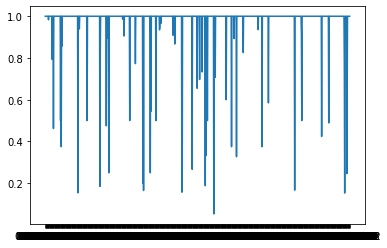

[(['0x20004640', '0x2001da48'], [0.0, 9.467455621301775e-05, 0.053]),
 (['0x20014360', '0x20004876'], [0.0, 0.026698224852070965, 0.153]),
 (['0x2000aa18', '0x200109ae'], [0.0, 0.027085207100591736, 0.154]),
 (['0x2001234a', '0x200074f8'], [0.0, 0.030223668639053333, 0.157]),
 (['0x2000d0fa', '0x2001ac46'], [0.0, 0.032707692307692285, 0.165]),
 (['0x2000b9fc', '0x2000b3d8'], [0.0, 0.010534911242603548, 0.167]),
 (['0x2001a3d8', '0x2001c76a'], [0.0, 0.02771715976331365, 0.167]),
 (['0x20015ee0', '0x20012858'], [0.0, 0.027178698224852117, 0.185]),
 (['0x200134a4', '0x20011452'], [0.0, 0.03716923076923076, 0.188]),
 (['0x200129ce', '0x200124f6'], [0.0, 0.026197633136094647, 0.2]),
 (['0x20009412', '0x200129be'], [0.0, 0.039635502958579906, 0.246]),
 (['0x20018e20', '0x20019238'], [0.0, 0.02337751479289942, 0.25]),
 (['0x20004b58', '0x20009ce4'], [0.0, 0.028932544378698292, 0.25]),
 (['0x20011138', '0x20011286'], [0.0, 0.03412662721893491, 0.267]),
 (['0x200133fc', '0x2000e98e'], [0.0, 0.0

In [24]:
proc_format = "instruction"
graphA = processOpCodes(main_graphA, proc_format=proc_format)
graphB = processOpCodes(main_graphB, proc_format=proc_format)
scores = calc_sim(compare_jaccard, graphA, graphB)
draw_results(scores)

In [25]:
# proc_format = "normalize3"
# graphA = processOpCodes(main_graphA, proc_format=proc_format)
# graphB = processOpCodes(main_graphB, proc_format=proc_format)
# proc_format = "instruction"
# graphA = processOpCodes(graphA, proc_format=proc_format)
# graphB = processOpCodes(graphB, proc_format=proc_format)
# scores = calc_sim(compare_jaccard, graphA, graphB)
# print(draw_results(scores))

In [26]:
# proc_format = "instruction"
# graphA = processOpCodes(main_graphA, proc_format=proc_format)
# graphB = processOpCodes(main_graphB, proc_format=proc_format)
# scores = calc_sim(compare_jaccard, graphA, graphB)
# draw_results(scores)

In [27]:
# scores = calc_sim(compare_tlsh)
# for i in range(len(scores)):
#         result = scores[i]
#         max_value = max(result)
#         scores[i] = [(1 - (x/max_value)) for x in result]
# draw_results(scores)

In [28]:
# scores = calc_sim(compare_2gram_jaccard)
# draw_results(scores)

In [29]:
# scores = calc_sim(compare_minhashA)
# # draw_results(scores)